In [1]:
import os
import numpy as np
import networkx as nx

from matching.glema.common.model import GLeMaNet
from matching.glema.common.model import InferenceGNN
import matching.glema.common.utils as utils
import matching.misc.cpg_const as cpg_const

In [2]:
args = utils.parse_args( use_default=True )
model_ckpt = "training/save/CPG_best_with_pivot_emb/best_model.pt"
args = utils.load_args( args, model_ckpt )
args.ckpt_path = model_ckpt
args.iso = True
args.test_data = True

In [3]:
model = InferenceGNN( args )

Loading model from training/save/CPG_best_with_pivot_emb/best_model.pt ...


In [4]:
def predict( model, G_source, G_query ) -> float:
    results = model.predict_label( [ G_query ], [ G_source ] )
    return results[ 0 ].item()

def is_subgraph( model, G_source, G_query, conf=0.5 ) -> bool:
    prediction = predict( model, G_source, G_query )
    print( f"query is subgraph of source: {prediction > conf} [{prediction:.3}]" )

In [5]:
record_scopes = utils.get_record_scopes( args )
design_patterns = utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [6]:
source_graph_idx = 0
query_subgraph_idx = 8

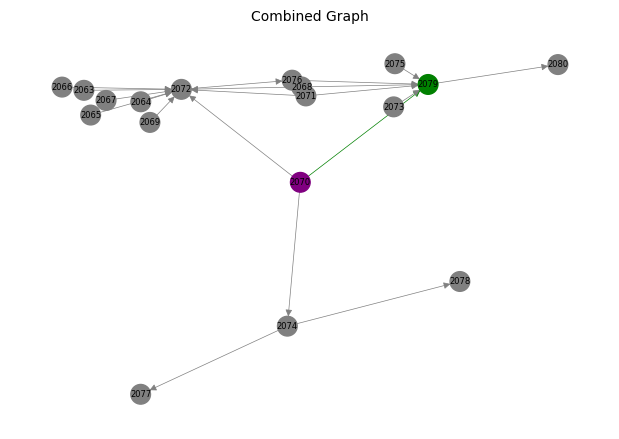

In [7]:
source = utils.load_source_graph( args, source_graph_idx )
query = utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined, node_colors, edge_colors = utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    #nodeLabels=utils.get_node_labels( combined, **label_args )
)

In [8]:
is_subgraph( model, source, query )

query is subgraph of source: True [0.987]


In [9]:
def compute_interactions(model, source_graph, query_graph, threshold):
    """Compute high-confidence interaction scores between nodes of the query graph and source graph."""
    interaction_matrix = model.predict_embedding([query_graph], [source_graph])[0].cpu().detach().numpy()
    x_coord, y_coord = np.where(interaction_matrix > threshold)
    n_query_nodes = query_graph.number_of_nodes()
    interaction_dict = { }
    for x, y in zip( x_coord, y_coord ):
        if x < n_query_nodes <= y:
            interaction_dict[ (x, y - n_query_nodes) ] = interaction_matrix[ x ][ y ]
        elif x >= n_query_nodes > y and (y, x - n_query_nodes) not in interaction_dict:
            interaction_dict[ (y, x - n_query_nodes) ] = interaction_matrix[ x ][ y ]
    return interaction_dict


def map_nodes(interactions, query_graph):
    """Map query graph nodes to source graph nodes based on interaction probabilities."""
    mapping = {}
    for q_node in query_graph.nodes:
        matches = [(g_node, score) for (q, g_node), score in interactions.items() if q == q_node]
        if matches:
            max_score = max(matches, key=lambda x: x[1])[1]
            mapping[q_node] = [g for g, s in matches if s == max_score]
        else:
            mapping[q_node] = []
    return mapping


def get_node_labels_and_colors(graph, mappings, ground_truth):
    """Get labels and colors for graph nodes based on predicted and ground-truth mappings."""
    labels = {node: "" for node in graph.nodes}
    for q_node, g_nodes in mappings.items():
        for g_node in g_nodes:
            labels[g_node] = f"{labels[g_node]},{q_node}" if labels[g_node] else str(q_node)

    colors = {node: "gray" for node in graph.nodes}
    for node, label in labels.items():
        if not label:
            colors[node] = "gold" if ground_truth[node] != -1 else "gray"
            continue
        if any(ground_truth[node] == int(q) for q in label.split(",")):
            colors[node] = "lime"
        elif colors[node] == "gray":
            colors[node] = "pink"

    for g_node, q_node in ground_truth.items():
        if not labels[g_node] and q_node != -1:
            labels[g_node] = str(q_node)
    return labels, colors


def get_edge_colors(graph, query_graph, labels, colors):
    """Assign colors to graph edges based on node mapping relationships."""
    edge_colors = {edge: "whitesmoke" for edge in graph.edges}
    for edge in graph.edges:
        n1, n2 = edge
        n1_labels, n2_labels = labels[n1], labels[n2]

        if colors[n1] == "gray" or colors[n2] == "gray":
            continue

        pairs = [
            (int(a), int(b))
            for a in n1_labels.split(",") for b in n2_labels.split(",")
            if (int(a), int(b)) not in query_graph.edges and (int(b), int(a)) not in query_graph.edges
        ]
        if len(pairs) < len(n1_labels.split(",")) * len(n2_labels.split(",")):
            if colors[n1] == "lime" and colors[n2] == "lime":
                edge_colors[edge] = "black"
            elif "gold" in {colors[n1], colors[n2]}:
                edge_colors[edge] = "goldenrod"
            elif "pink" in {colors[n1], colors[n2]}:
                edge_colors[edge] = "palevioletred"
        elif "pink" in {colors[n1], colors[n2]}:
            edge_colors[edge] = "palevioletred"

    return edge_colors


def plot_interactions(args, model, src_idx, query_idx, threshold=0.5):
    """Compute interactions and plot the graph with matched subgraph highlights."""
    src_graph = utils.load_source_graph(args, src_idx, relabel=False)
    query_graph = utils.load_query_graph(args, src_idx, query_idx, relabel=False)
    ground_truth = utils.load_query_id_mapping(args, src_idx, query_idx, flip=False)

    interactions = compute_interactions(model, src_graph, query_graph, threshold)
    mappings = map_nodes(interactions, query_graph)
    labels, colors = get_node_labels_and_colors(src_graph, mappings, ground_truth)
    edges = get_edge_colors(src_graph, query_graph, labels, colors)

    utils.plot_graph(
        src_graph,
        nodeLabels=labels,
        nodeColors=list(colors.values()),
        edgeColors=list(edges.values()),
        title="Matching",
        with_label=True,
    )

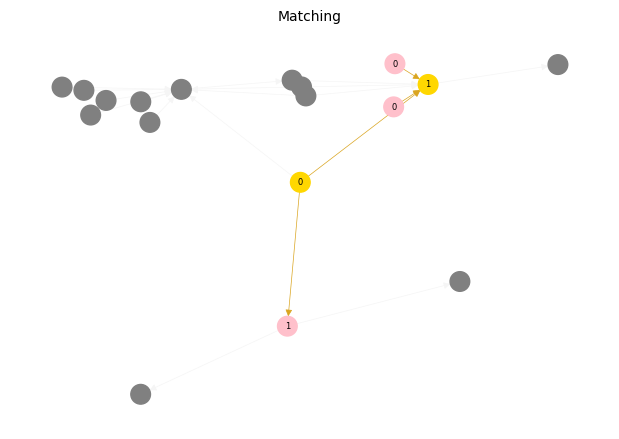

In [10]:
plot_interactions( args, model, source_graph_idx, query_subgraph_idx )

In [11]:
def addCpgNode( G : nx.DiGraph(), label : cpg_const.NodeLabel, pivot=False ):
    node_id = G.number_of_nodes()
    pivot_idx = 1 if pivot else 0
    G.add_node( node_id, label=utils.get_enum_idx( label ), pivot=pivot_idx )
    return node_id

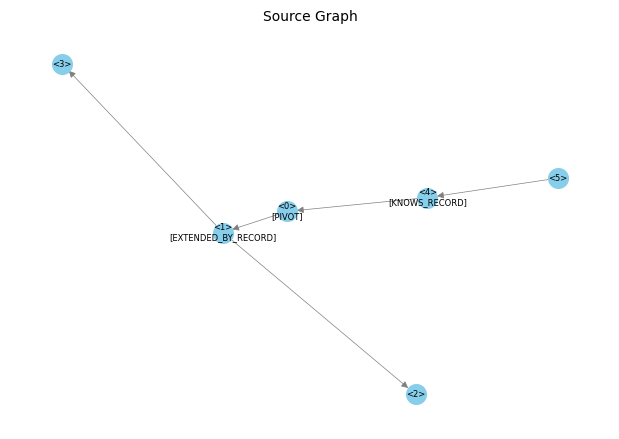

In [12]:
test_source = nx.DiGraph()
node_a = addCpgNode( test_source, cpg_const.NodeLabel.RECORD, pivot=True )
node_b = addCpgNode( test_source, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
node_c = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_d = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_e = addCpgNode( test_source, cpg_const.NodeLabel.KNOWS_RECORD )
node_f = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
test_source.add_edge( node_a, node_b )
test_source.add_edge( node_b, node_c )
test_source.add_edge( node_b, node_d )
test_source.add_edge( node_f, node_e )
test_source.add_edge( node_e, node_a )

utils.plot_graph( test_source,
                  title="Source Graph",
                  nodeLabels=utils.get_node_labels( test_source ) )

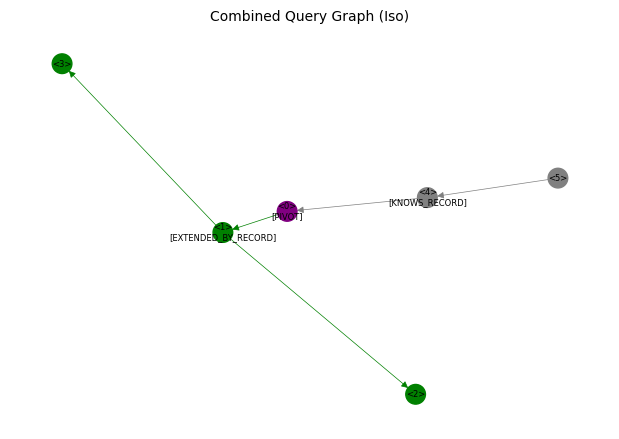

query is subgraph of source: True [0.972]


In [13]:
test_query_iso = nx.DiGraph()
node_a = addCpgNode( test_query_iso, cpg_const.NodeLabel.RECORD, pivot=True )
node_b = addCpgNode( test_query_iso, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
node_c = addCpgNode( test_query_iso, cpg_const.NodeLabel.RECORD )
node_d = addCpgNode( test_query_iso, cpg_const.NodeLabel.RECORD )
test_query_iso.add_edge( node_a, node_b )
test_query_iso.add_edge( node_b, node_c )
test_query_iso.add_edge( node_b, node_d )

combined, node_colors, edge_colors = utils.combine_graph( test_source, test_query_iso,
                                                          matching_colors=matching_colors )
utils.plot_graph(
    title="Combined Query Graph (Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_iso )

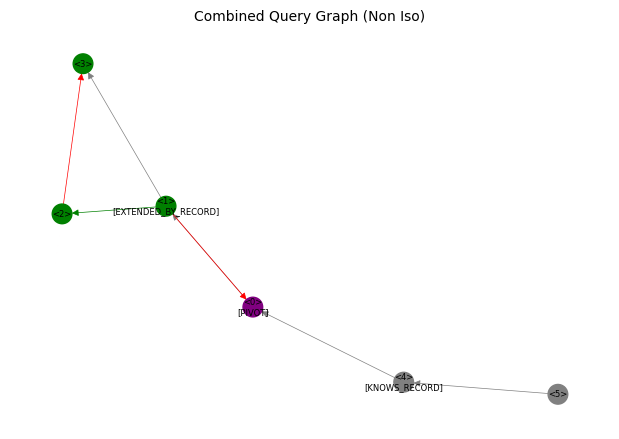

query is subgraph of source: False [0.0518]


In [14]:
test_query_non_iso = nx.DiGraph()
node_a = addCpgNode( test_query_non_iso, cpg_const.NodeLabel.RECORD, pivot=True )
node_b = addCpgNode( test_query_non_iso, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
node_c = addCpgNode( test_query_non_iso, cpg_const.NodeLabel.RECORD )
node_d = addCpgNode( test_query_non_iso, cpg_const.NodeLabel.RECORD )
test_query_non_iso.add_edge( node_b, node_a )
test_query_non_iso.add_edge( node_b, node_c )
test_query_non_iso.add_edge( node_c, node_d )

combined, node_colors, edge_colors = utils.combine_graph( test_source, test_query_non_iso,
                                                          matching_colors=matching_colors )
utils.plot_graph(
    title="Combined Query Graph (Non Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=utils.get_node_labels( combined )
)

is_subgraph( model, test_source, test_query_non_iso )